In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import features
from glob import glob
from tqdm import tqdm
from PIL import Image

In [8]:
celltowers = gpd.read_file("Data/celltowers/shapefiles/CellularTowers.shp")
ca_cells = celltowers[celltowers["LOCSTATE"] == "CA"]

open_path = glob("./Data/sentinel2/ca/composite/*.tif")
save_path = "./Data/celltowers/sentinel2/"

In [9]:
def cellraster_from_sat(cells, path):
    with rio.open(path) as dataset:

        satimg = dataset.read()
        mask = dataset.dataset_mask()
        sat_trs = dataset.transform
        sat_crs = dataset.crs

        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                rio.features.shapes(mask, transform=dataset.transform)))

    sat = gpd.GeoDataFrame.from_features(list(results),crs=sat_crs)
    cells = cells.to_crs(sat_crs)
    intersects = cells[cells.intersects(sat.unary_union)]
    cells_array = [(geom.buffer(400,20), 1) for geom in intersects["geometry"]]
    cells_raster = features.rasterize(cells_array,np.shape(satimg[0]),transform=sat_trs)
    return Image.fromarray(cells_raster)

In [13]:
for path in tqdm(open_path):
    sat_id = path.split("\\")[1].split(".")[0]
    cellraster = cellraster_from_sat(ca_cells, path)
    cellraster.save(save_path+sat_id+".tif")

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
  7%|▋         | 1/15 [00:01<00:18,  1.30s/it]C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
 13%|█▎        | 2/15 [00:02<00:17,  1.33s/it]C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


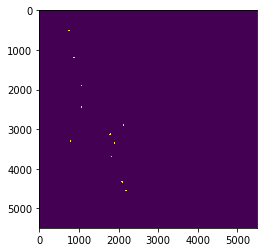

In [11]:
%pylab
%matplotlib inline
imshow(cellraster)